In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)

In [3]:
def greens_function(config, old_config, alpha, beta, kappa, gamma, delta_t):
    norm_diff = np.linalg.norm(config - old_config)
    return (1/np.sqrt(4*np.pi* gamma*delta_t)) * np.exp(-norm_diff**2 / (4*gamma*delta_t))

In [4]:
def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*(r_1+r_2))*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array([force_1, force_2])

def metropolis_algorithm(initial_state, num_trials, s, alpha, beta, kappa, use_FP = False):
    sequence_states = [initial_state]
    for n in tqdm(range(num_trials)):
        next_sequence = metropolis_step(sequence_states[-1], alpha, beta, s, kappa, use_FP=use_FP)
        sequence_states.append(next_sequence)
    return np.array(sequence_states)
    
def metropolis_step(current_state, alpha, beta, s, kappa, use_FP = False):
    trial_configuration = current_state.copy()
    current_r_1 = current_state[:M]
    current_r_2 = current_state[M:]

    which_particle = np.random.choice([0,M])
    for i in range(M):
        if use_FP:
            trial_configuration[i+which_particle] += Fokker_planck(current_r_1, current_r_2, alpha, kappa = 2, beta = 0.5)*delta_t/2
        trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)#*np.sqrt(delta_t)
    trial_r_1 = trial_configuration[:M]
    trial_r_2 = trial_configuration[M:]
    if not use_FP:
        trial_acceptance_prob = np.min([1, (psi_T(trial_r_1, trial_r_2, alpha, kappa, beta)/psi_T(current_r_1, current_r_2, alpha, kappa, beta))**2])
    r_accept = np.random.rand()
    if r_accept < trial_acceptance_prob:
        new_state = trial_configuration
    else:
        new_state = current_state
    return np.array(new_state)


In [7]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), -vec_r12/r_12)
    E_L = (kappa-2)/r_1 + (kappa-2)/r_2 + (1-2*beta/u**2) +2*beta*alpha/u**3 - kappa**2 - (beta**2)/u**4 +(kappa*beta/u**2)*scalar_product    
    return E_L

def energy_statistics(simulation, accumulate_last_n, alpha, beta, kappa):
    energies = []
    num_simulation_steps = simulation.shape[0]

    for time in tqdm(range(num_simulation_steps)):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            energies_t.append(e_i)
        energies.append(energies_t)  
    e_avg_accumulated = [np.mean(energies[0])]
    e_var_accumulated = [np.std(energies[0])]
    for time in tqdm(range(1, num_simulation_steps)):
        if time > accumulate_last_n:
            e_avg_t = np.mean(energies[time-accumulate_last_n:time])
            e_var_t = np.std(energies[time-accumulate_last_n:time])
        else: #For the first 999 time steps:
            e_avg_t = np.mean(energies[:time])
            e_var_t = np.std(energies[:time])              
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.array(e_var_accumulated)

In [8]:
sim = metropolis_algorithm(R, num_trials=30000, s=0.1, alpha=0.15, beta=0.5, kappa=2)
E_avg_s, E_std_s = energy_statistics(sim, 1000, alpha=0.15, beta=0.5, kappa=2)

 27%|██▋       | 8211/30000 [1:32:30<4:05:28,  1.48it/s]    

KeyboardInterrupt



In [ ]:
plt.plot(np.arange(sim.shape[0]), E_avg_s)
plt.fill_between(np.arange(sim.shape[0]), E_avg_s-E_std_s, E_avg_s+E_std_s, alpha=0.3)

In [37]:
timestep = 0
walker = 0
sim_step_r1 = sim[timestep, walker, :]
sim_step_r2 = sim[timestep, walker+M, :]
e = energy_local(sim_step_r1, sim_step_r2, alpha=0.15, beta=0.5, kappa=2)

print(sim_step_r1)
print(sim_step_r2)
print(e)

[ 0.47111873  0.07798355 -0.45012105]
[ 0.10389725 -0.46783266  0.10703362]
-2.6745152843362465


In [40]:
N = 30000
n = 1000
list_s = [0.1,1,10]

E_avg = []
E_std = []

for s_test in list_s:
    print(f"s = {s_test}:")
    simulation_s = metropolis_algorithm(R, N, s_test, alpha=0.15, beta=0.5, kappa=2)
    E_avg_s, E_std_s = energy_statistics(simulation_s, n, alpha=0.15, beta=0.5, kappa=2)
    E_avg.append(E_avg_s)
    E_std.append(E_std_s)

s = 0.1:


100%|██████████| 30001/30001 [03:32<00:00, 140.85it/s]


s = 1:


100%|██████████| 30001/30001 [03:51<00:00, 129.77it/s]


s = 10:


100%|██████████| 30001/30001 [03:19<00:00, 150.47it/s]


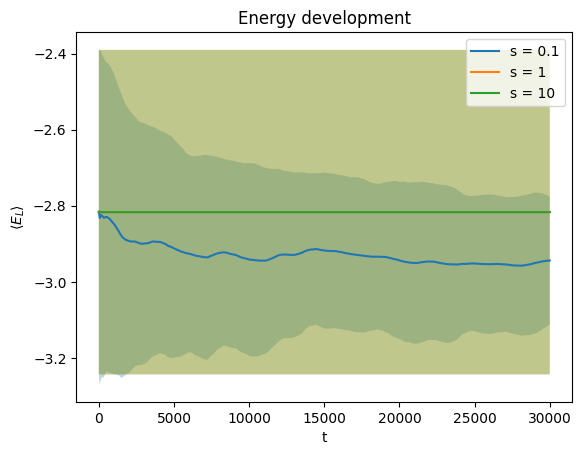

In [41]:
t = np.arange(N+1)
for i in range(len(E_avg)):
    plt.fill_between(t, E_avg[i]-E_std[i], E_avg[i]+E_std[i], alpha=0.3)
    plt.plot(t, E_avg[i], label=f"s = {list_s[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

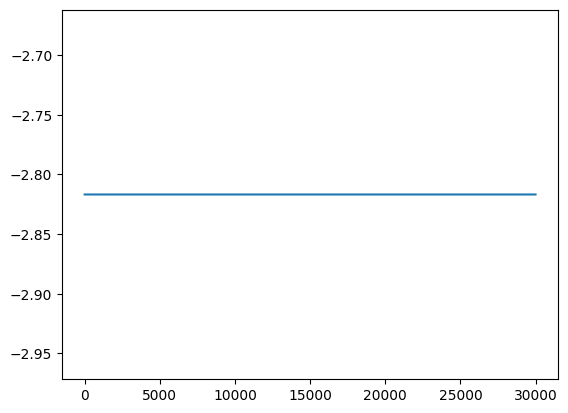

In [42]:
plt.plot(t, E_avg[1], label="s = s=1")

# Problem b

In [44]:
list_alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

E_avg_alpha = []
E_std_alpha = []

for alpha in list_alpha:
    print(rf"$\alpha$ = {alpha}:")
    simulation_a = metropolis_algorithm(R, N, s=1, alpha=alpha, beta=0.5, kappa=2)
    E_avg_a, E_std_a = energy_statistics(simulation_a, n, alpha=alpha, beta=0.5, kappa=2)
    E_avg_alpha.append(E_avg_a)
    E_std_alpha.append(E_std_a)

$\alpha$ = 0.0:


100%|██████████| 30001/30001 [06:22<00:00, 78.49it/s] 


$\alpha$ = 0.1:


 86%|████████▋ | 25903/30001 [05:06<00:48, 84.59it/s] 


KeyboardInterrupt: 

In [ ]:
for i in range(len(E_avg)):
    plt.fill_between(t, E_avg_alpha[i]-E_std_alpha[i], E_avg_alpha[i]+E_std_alpha[i], alpha=0.3)
    plt.plot(t, E_avg_alpha[i], label= rf"$\alpha$ = {list_alpha[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

# Problem c

In [ ]:
def energy_statistics_c(simulation, equilibration_time, alpha=0.15, beta=0.5, kappa=2): # Todo: If change in energy_statistics function is made, it may be necessary to change it here as well
    energies = []
    num_simulation_steps = simulation.shape[0]
    for time in tqdm(range(num_simulation_steps)):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            energies_t.append(e_i)
        energies.append(energies_t)
    e_avg = np.mean(energies, axis=1)
    var_E = np.std(energies, axis=1)   
    e_avg_accumulated = [e_avg[0]]
    e_var_accumulated = [var_E[0]]
    for time in range(equilibration_time+1, num_simulation_steps):
        e_avg_t = np.mean(e_avg[equilibration_time:time])
        e_var_t = np.mean(var_E[equilibration_time:time])
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.array(e_var_accumulated)

In [ ]:
n_equilibrium = 5000 # Todo: Choose appropriate value

list_alpha_c = np.linspace(0,0.5,50)

E_avg_alpha_c = []
E_std_alpha_c = []

for alpha in list_alpha_c:
    simulation_a = metropolis_algorithm(R, N, s=1, alpha=alpha, beta=0.5, kappa=2)
    E_avg_a, E_std_a = energy_statistics_c(simulation_a, n_equilibrium, alpha=alpha, beta=0.5, kappa=2)
    E_avg_alpha_c.append(E_avg_a)
    E_std_alpha_c.append(E_std_a)

# Problem d

In [ ]:
alpha_optimal = 2 # Todo: Select optimal alpha from problem part c

list_kappa = np.linspace(1.7,2.2,50)

E_avg_alpha_c = []
E_std_alpha_c = []

for k in list_kappa:
    simulation_a = metropolis_algorithm(R, N, s=1, alpha=alpha_optimal, beta=0.5, kappa=k)
    E_avg_a, E_std_a = energy_statistics_c(simulation_a, n_equilibrium)
    E_avg_alpha_c.append(E_avg_a)
    E_std_alpha_c.append(E_std_a)

# Problem e

In [ ]:
beta_e = 0.38
alpha_e = 0.18 
kappa_e = 1.85

# Problem g

In [ ]:
metropolis_algorithm(initial_state, N, s=1, alpha_e, beta_e, kappa_e, use_FP = False)